## Problem 2. Reinforcement Learning for BipedalWalker-v3 (35 points)
This problem is to design a reinforcement learning algorithm that is applied to a robot, with the objective to maximize its reward, in the following game. 
### BipedalWalker-v3
The reward is given for moving forward, accumulating over 300 points at the end. If the robot falls, it will be penalized by deducting 100 points. Applying a motor torque costs a small amount of points. The state of the robot consists of hull angle speed, angular velocity, horizontal speed, vertical speed, positions of joints, angular speeds of joints, contact positions of legs with the ground, and 10 lidar rangefinder measurements. There is no coordinate in the state vector.  
![Alt Text](https://media.giphy.com/media/R89toZzap04ZDKHPkd/giphy.gif)  
This game has continuous action space. You are required to apply the Twin Delayed DDPG (TD3) method in this game.  
### References：
You can read [this link](https://spinningup.openai.com/en/latest/algorithms/td3.html) to understand the **TD3** algorithm better.  
You can visit [this link](https://dllglobal.com/challenges/reinforcement-learning) to understand the **BipedalWalker-v3** environment better.  
### Requirements：
* All of your code should be shown in this file.
* Your network must be based on GRU; otherwise, you will get 0 point.
* You must save your trained model named as **best_model.pt**.
* The RL method you need to implement is TD3; otherwise you will get 0 point.
* Please give some comments to your code.

### 2.1 Import the packages and define helper funcitons and variables (5 points)

In [1]:
import gym
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm.notebook as tn
import numpy as np
import time
from collections import deque
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image



class ReplayBuffer:
    def __init__(self, max_size=5e5):
        self.buffer = []
        self.max_size = int(max_size)
        self.size = 0
    
    def add(self, transition):
        self.size +=1
        # transiton is tuple of (state, action, reward, next_state, done)
        self.buffer.append(transition)
    
    def sample(self, batch_size):
        # delete 1/5th of the buffer when full
        if self.size > self.max_size:
            del self.buffer[0:int(self.size/5)]
            self.size = len(self.buffer)
        
        indexes = np.random.randint(0, len(self.buffer), size=batch_size)
        state, action, reward, next_state, done = [], [], [], [], []
        
        for i in indexes:
            s, a, r, s_, d = self.buffer[i]
            state.append(np.array(s, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            next_state.append(np.array(s_, copy=False))
            done.append(np.array(d, copy=False))
        
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

### 2.2 Build your network (<font color=red>which should include GRU cells</font>) (7 points)

In [2]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.GRU_layer = nn.GRU(input_size=state_dim, hidden_size=state_dim ,num_layers=1)
        self.l1 = nn.Linear(state_dim, 480)
        self.l2 = nn.Linear(480, 240)
        self.l3 = nn.Linear(240, action_dim)

        self.max_action = max_action

    def forward(self, state):
        state=state.unsqueeze(0)
        a , self.hidden = self.GRU_layer(state)
        a = a.squeeze(0)
        a = F.relu(self.l1(a))
        a = F.relu(self.l2(a))
        a = torch.tanh(self.l3(a)) * self.max_action
        return a


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, 560)
        self.l2 = nn.Linear(560, 280)
        self.l3 = nn.Linear(280, 1)

    def forward(self, state, action):
        state_action = torch.cat([state, action], 1)

        q = F.relu(self.l1(state_action))
        q = F.relu(self.l2(q))
        q = self.l3(q)
        return q

### 2.3 Define your TD3 algorithm (8 points)

In [3]:
# 请用GPU，不然宛若智障
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class TD3:
    def __init__(self, lr, state_dim, action_dim, max_action):
        
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        
        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_1_target = Critic(state_dim, action_dim).to(device)
        self.critic_1_target.load_state_dict(self.critic_1.state_dict())
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=lr)
        
        self.critic_2 = Critic(state_dim, action_dim).to(device)
        self.critic_2_target = Critic(state_dim, action_dim).to(device)
        self.critic_2_target.load_state_dict(self.critic_2.state_dict())
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=lr)
        
        self.max_action = max_action
    
    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()
    
    def update(self, replay_buffer, n_iter, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay):
        
        for i in range(n_iter):
            # Sample a batch of transitions from replay buffer:
            state, action_, reward, next_state, done = replay_buffer.sample(batch_size)
            state = torch.FloatTensor(state).to(device)
            action = torch.FloatTensor(action_).to(device)
            reward = torch.FloatTensor(reward).reshape((batch_size,1)).to(device)
            next_state = torch.FloatTensor(next_state).to(device)
            done = torch.FloatTensor(done).reshape((batch_size,1)).to(device)
            
            # Select next action according to target policy:
            noise = torch.FloatTensor(action_).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            next_action = (self.actor_target(next_state) + noise)
            next_action = next_action.clamp(-self.max_action, self.max_action)
            
            # Compute target Q-value:
            target_Q1 = self.critic_1_target(next_state, next_action)
            target_Q2 = self.critic_2_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + ((1-done) * gamma * target_Q).detach()
            
            # Optimize Critic 1:
            current_Q1 = self.critic_1(state, action)
            loss_Q1 = F.mse_loss(current_Q1, target_Q)
            self.critic_1_optimizer.zero_grad()
            loss_Q1.backward()
            self.critic_1_optimizer.step()
            
            # Optimize Critic 2:
            current_Q2 = self.critic_2(state, action)
            loss_Q2 = F.mse_loss(current_Q2, target_Q)
            self.critic_2_optimizer.zero_grad()
            loss_Q2.backward()
            self.critic_2_optimizer.step()
            
            # Delayed policy updates:
            if i % policy_delay == 0:
                # Compute actor loss:
                actor_loss = -self.critic_1(state, self.actor(state)).mean()
                
                # Optimize the actor
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()
                
                # Polyak averaging update:
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_1.parameters(), self.critic_1_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
                
                for param, target_param in zip(self.critic_2.parameters(), self.critic_2_target.parameters()):
                    target_param.data.copy_( (polyak * target_param.data) + ((1-polyak) * param.data))
        return actor_loss.cpu().data.numpy(), loss_Q1.cpu().data.numpy(), loss_Q2.cpu().data.numpy()
                
    def save(self, directory, name, ep):
        torch.save(self.actor.state_dict(), '%s/%s_actor_ep%s.pth' % (directory, name, ep))
        torch.save(self.actor_target.state_dict(), '%s/%s_actor_target_ep%s.pth' % (directory, name, ep))
        
        torch.save(self.critic_1.state_dict(), '%s/%s_crtic_1_ep%s.pth' % (directory, name, ep))
        torch.save(self.critic_1_target.state_dict(), '%s/%s_critic_1_target_ep%s.pth' % (directory, name, ep))
        
        torch.save(self.critic_2.state_dict(), '%s/%s_crtic_2_ep%s.pth' % (directory, name, ep))
        torch.save(self.critic_2_target.state_dict(), '%s/%s_critic_2_target_ep%s.pth' % (directory, name, ep))
        
    def load(self, directory, name, ep):
        self.actor.load_state_dict(torch.load('%s/%s_actor_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        
        self.critic_1.load_state_dict(torch.load('%s/%s_crtic_1_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        self.critic_1_target.load_state_dict(torch.load('%s/%s_critic_1_target_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        
        self.critic_2.load_state_dict(torch.load('%s/%s_crtic_2_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        self.critic_2_target.load_state_dict(torch.load('%s/%s_critic_2_target_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
            
    def load_actor(self, directory, name, ep):
        self.actor.load_state_dict(torch.load('%s/%s_actor_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))
        self.actor_target.load_state_dict(torch.load('%s/%s_actor_target_ep%s.pth' % (directory, name, ep), map_location=lambda storage, loc: storage))    

### 2.4 Define your training process and train your model (5 points)  
You must use some data structures to collect the mean reward and mean loss in each iteration.

In [4]:
# 设置各种参数
gym.logger.set_level(40)
env_name = "BipedalWalker-v3"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

log_interval = 100  # print avg reward after interval，并且决定多久检查一次是否训练完成
random_seed = 0
gamma = 0.99  # discount for future rewards
batch_size = 100  # num of transitions sampled from replay buffer
lr = 0.001
exploration_noise = 0.1
polyak = 0.995  # target policy update parameter (1-tau)
policy_noise = 0.2  # target policy smoothing noise
noise_clip = 0.5
policy_delay = 2  # delayed policy updates parameter
max_episodes = 10000  # max num of episodes
max_timesteps = 2000  # max timesteps in one episode 这个指让他一次能跑多久，避免站住不动了
directory = "./preTrained/"  # save trained models
filename = "TD3_{}_{}".format(env_name, random_seed)

start_episode = 0


policy = TD3(lr, state_dim, action_dim, max_action)
replay_buffer = ReplayBuffer()

if random_seed:
    print("Random Seed: {}".format(random_seed))
    env.seed(random_seed)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

LOAD = False
if LOAD:
    start_episode = 1000
    policy.load(directory, filename, str(start_episode))

# logging variables:
scores = []
mean_scores = []
last_scores = deque(maxlen=log_interval)
distances = []
mean_distances = []
last_distance = deque(maxlen=log_interval)
losses_mean_episode = []

# training procedure:
for ep in tn.tqdm(range(start_episode + 1, max_episodes + 1)):

    state = env.reset()
    total_reward = 0
    total_distance = 0
    actor_losses = []
    c1_losses = []
    c2_losses = []
    

    for t in range(max_timesteps):

        # select action and add exploration noise:
        action = policy.select_action(state)
        action = action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])
        action = action.clip(env.action_space.low, env.action_space.high)

        # take action in env:
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state

        total_reward += reward
        if reward != -100:
            total_distance += reward     
        if ep >= 100:
            env.render()
        # if episode is done then update policy:
        if done or t == (max_timesteps - 1):
            actor_loss, c1_loss, c2_loss = policy.update(replay_buffer, t, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay)
            actor_losses.append(actor_loss)
            c1_losses.append((c1_loss))
            c2_losses.append(c2_loss)
#             print('reward_it',t)
            break
    mean_loss_actor = np.mean(actor_losses)
    mean_loss_c1 = np.mean(c1_losses)
    mean_loss_c2 = np.mean(c2_losses)
    losses_mean_episode.append((ep, mean_loss_actor, mean_loss_c1, mean_loss_c2))
    print('\rEpisode: {}/{},\tScore: {:.2f},\tDistance: {:.2f},\tactor_loss: {},\tc1_loss:{},\tc2_loss:{}'
        .format(ep, max_episodes,total_reward,total_distance,mean_loss_actor,mean_loss_c1, mean_loss_c2),end="")

    # logging updates:
    scores.append(total_reward)
    distances.append(total_distance)
    last_scores.append(total_reward)
    last_distance.append(total_distance)
    mean_score = np.mean(last_scores)
    mean_distance = np.mean(last_distance)
    FILE = 'record.dat'
    data = [ep, total_reward, total_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2]
    with open(FILE, "ab") as f:
        pickle.dump(data, f)

    # print avg reward every log interval:
    if ep % log_interval == 0:
        policy.save(directory, filename, str(ep))
        mean_scores.append(mean_score)
        mean_distances.append(mean_distance)
        print('\rEpisode: {}/{},\tMean Score: {:.2f},\tMean Distance: {:.2f},\tactor_loss: {},\tc1_loss:{},\tc2_loss:{}'
            .format(ep, max_episodes, mean_score, mean_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2))
        FILE = 'record_mean.dat'
        data = [ep, mean_score, mean_distance, mean_loss_actor, mean_loss_c1, mean_loss_c2]
        with open(FILE, "ab") as f:
            pickle.dump(data, f)
#         if mean_score >= 300 and len(last_scores) == log_interval:
        if mean_score >= 300:
            print("########## Solved! ###########")
            name = 'best_model'
            policy.save(directory, name, str(ep))
            break
env.close()

Episode: 100/10000,	Mean Score: -112.56,	Mean Distance: -15.56,	actor_loss: -4.614438533782959,	c1_loss:3.3049795627593994,	c2_loss:3.189073324203491
Episode: 200/10000,	Mean Score: -119.31,	Mean Distance: -20.31,	actor_loss: 17.5176944732666,	c1_loss:4.583554744720459,	c2_loss:5.577582836151123
Episode: 300/10000,	Mean Score: -119.08,	Mean Distance: -66.08,	actor_loss: 6.050421237945557,	c1_loss:1.154899001121521,	c2_loss:1.2749778032302856
Episode: 400/10000,	Mean Score: -101.31,	Mean Distance: -93.31,	actor_loss: 8.42099666595459,	c1_loss:0.3020227551460266,	c2_loss:0.4028629660606384
Episode: 500/10000,	Mean Score: -81.94,	Mean Distance: -77.94,	actor_loss: 6.931403636932373,	c1_loss:1.3918050527572632,	c2_loss:2.6339659690856934
Episode: 600/10000,	Mean Score: -65.77,	Mean Distance: -57.77,	actor_loss: 4.36439847946167,	c1_loss:0.01097493339329958,	c2_loss:0.01079590804874897
Episode: 700/10000,	Mean Score: -33.60,	Mean Distance: -29.60,	actor_loss: 2.517826557159424,	c1_loss:0.00

KeyboardInterrupt: 

### 2.5 Show your change curves of reward and loss in two sub-pictures (5 points)
Your reward and loss must be able to converge; otherwise this part will get 0 point.

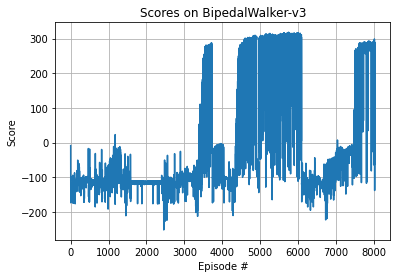

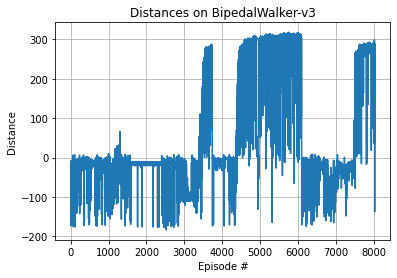

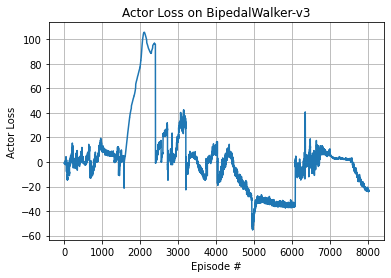

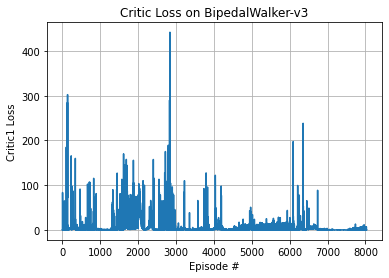

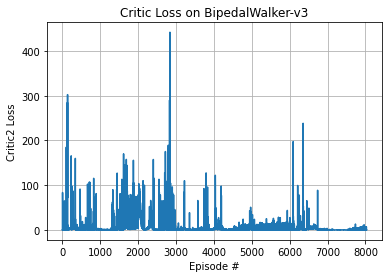

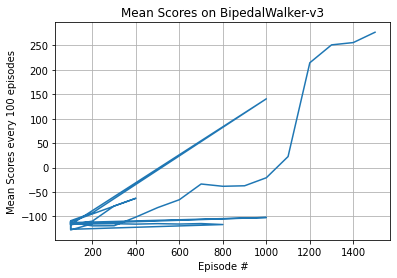

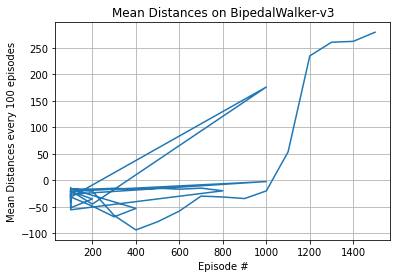

In [5]:
data = []
with open('./record.dat', 'rb') as fr:
    try:
        while True:
            data.append(pickle.load(fr))
    except EOFError:
        pass
data = pd.DataFrame(np.array(data))

scores = []
distances = []
actor_losses = []
critic1_losses = []
critic2_losses = []


for r in data[1]:
    scores.append(r)

for r in data[2]:
    distances.append(r)

for r in data[3]:
    actor_losses.append(r)

for r in data[4]:
    critic1_losses.append(r)

for r in data[4]:
    critic2_losses.append(r)

data_mean = []
with open('./record_mean.dat', 'rb') as record_mean:
    try:
        while True:
            data_mean.append(pickle.load(record_mean))
    except EOFError:
        pass
data_mean = pd.DataFrame(np.array(data_mean))

episode = []
scores_mean = []
distances_mean = []

for r in data_mean[0]:
    episode.append(r)

for r in data_mean[1]:
    scores_mean.append(r)

for r in data_mean[2]:
    distances_mean.append(r)


# plot
fig = plt.figure()
ax = fig.add_subplot(111)

x = np.arange(1, len(scores) + 1)
y = scores
plt.plot(x, y)
plt.grid()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Scores on BipedalWalker-v3')
plt.show()
namefig = "plot/scores_TD3_episodes" + str(data.shape[0]) + ".jpg"
fig.savefig(namefig, dpi=300)

# plot the distance and mean
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(distances) + 1)
y = distances
plt.plot(x, y)
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Episode #')
plt.title('Distances on BipedalWalker-v3')
plt.show()
namefig = "plot/distances_TD3_episodes" + str(data.shape[0]) + ".jpg"
fig.savefig(namefig, dpi=300)



# plot the loss
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(actor_losses) + 1)
y = actor_losses
plt.plot(x, y)
plt.grid()
plt.ylabel('Actor Loss')
plt.xlabel('Episode #')
plt.title('Actor Loss on BipedalWalker-v3')
plt.show()
namefig = "plot/actor_loss_TD3_episodes" + str(data.shape[0]) + ".jpg"
fig.savefig(namefig, dpi=300)

fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(critic1_losses) + 1)
y = critic1_losses
plt.plot(x, y)
plt.grid()
plt.ylabel('Critic1 Loss')
plt.xlabel('Episode #')
plt.title('Critic Loss on BipedalWalker-v3')
plt.show()
namefig = "plot/critic1_loss_TD3_episodes" + str(data.shape[0]) + ".jpg"
fig.savefig(namefig, dpi=300)

fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(critic2_losses) + 1)
y = critic2_losses
plt.plot(x, y)
plt.grid()
plt.ylabel('Critic2 Loss')
plt.xlabel('Episode #')
plt.title('Critic Loss on BipedalWalker-v3')
plt.show()
namefig = "plot/critic2_loss_TD3_episodes" + str(data.shape[0]) + ".jpg"
fig.savefig(namefig, dpi=300)



# plot
fig = plt.figure()
ax = fig.add_subplot(111)
x = episode
y = scores_mean
plt.plot(x, y)
plt.grid()
plt.ylabel('Mean Scores every 100 episodes')
plt.xlabel('Episode #')
plt.title('Mean Scores on BipedalWalker-v3')
plt.show()
namefig = "plot/mean_scores_TD3_episodes" + str(data.shape[0]) + ".jpg"
fig.savefig(namefig, dpi=300)

# plot the distance and mean
fig = plt.figure()
ax = fig.add_subplot(111)
x = episode
y = distances_mean
plt.plot(x, y)
plt.grid()
plt.ylabel('Mean Distances every 100 episodes')
plt.xlabel('Episode #')
plt.title('Mean Distances on BipedalWalker-v3')
plt.show()
namefig = "plot/mean_distances_TD3_episodes" + str(data.shape[0]) + ".jpg"
fig.savefig(namefig, dpi=300)

### 2.6 Test your model 10 times and print the mean reward (5 points) 
You should load your trained model **best_model.pt**. If your mean reward is >= 200 but < 250, you will get 3 points. If your mean reward is >= 250, you will get 5 points. If your mean reward is < 200, you will get 0 point.

In [ ]:
gym.logger.set_level(40)
env_name = "BipedalWalker-v3"
random_seed = 0
n_episodes = 100
lr = 0.002
max_timesteps = 2000
render = True
save_gif = False

# filename = "TD3_{}_{}".format(env_name, random_seed)
# filename += '_solved'
filename='best_model'
directory = "./preTrained".format(env_name)
# episode = ep
episode = 1909

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

policy = TD3(lr, state_dim, action_dim, max_action)

policy.load_actor(directory, filename, episode)

scores = []

for ep in range(1, n_episodes+1):
    ep_reward = 0
    state = env.reset()
    for t in range(max_timesteps):
        action = policy.select_action(state)
        state, reward, done, _ = env.step(action)
        ep_reward += reward
        if render:
            env.render()
            if save_gif:
                img = env.render(mode = 'rgb_array')
                img = Image.fromarray(img)
                img.save('./gif/{}.jpg'.format(t))
        if done:
            break
    scores.append(ep_reward)
    #print('Episode: {}\tReward: {}'.format(ep, int(ep_reward)))
    env.close()


print("Score media", np.mean(scores))
    
# plot
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(scores) + 1)
y = scores
plt.plot(x, y)
plt.grid()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Test Scores on BipedalWalker-v3')
plt.show()
namefig = "plot/test_scores_TD3_episodes" + str(episode) + ".jpg"
fig.savefig(namefig, dpi=300)